## 1. Environmental Setup

### 1.1 Load Libraries

In [1]:
# =============================================================================
# 1. Load Libraries
# =============================================================================
import os
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow

from pyproj import Transformer
from rasterio.enums import Resampling

### 1.2 Set Parameters

In [ ]:
# =============================================================================
# 2. Set the parameters
# =============================================================================

# Input raster maps:
# path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\pixel2"
# path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\object2"
# time_points = [2010, 2012, 2014, 2016, 2018, 2021]
# class_name = "PIE"
# is_binary_data = True # Set to True for 0/1 data

# path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\collection6"
path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\collection8"
time_points = [1990, 1995, 2000, 2005, 2010, 2015, 2020]
class_name = "savanna"
is_binary_data = True # Set to True for 0/1 data

# path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\toydata\x"
# path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\toydata\y"
# time_points = [0, 1, 2]
# class_name = "toydata"
# is_binary_data = True # Set to True for 0/1 data

# Output folder
output_path = r"C:\Users\AntFonseca\github\compare-time-series\output4"
if not os.path.exists(output_path):
    os.makedirs(output_path)

# NoData values
nodata_value = -128

print("✅ Parameters successfully defined.")

✅ Parameters successfully defined.


## 2. Definition of Caculation Functions

In [3]:
# =============================================================================
# 2. definition of all calculation functions
# =============================================================================

# 2.1 helper function for data reading
# =====================================
raster_arrays = {}

def get_raster_array(year):
    """
    Reads a pair of raster files (x and y) for a given year or returns it from the
    cache if it has already been read previously in this cell.
    """
    if year in raster_arrays:
        return raster_arrays[year]
    
    file_name = f"{class_name}{year}.tif"
    path_x = os.path.join(
        path_series_x,
        file_name
    )
    path_y = os.path.join(
        path_series_y,
        file_name
    )

    if not os.path.exists(path_x) or not os.path.exists(path_y):
        print(f"Warning: File '{file_name}' not found for year {year}.")
        return None, None

    with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
        array_x = src_x.read(1)
        array_y = src_y.read(1)
        raster_arrays[year] = (array_x, array_y)
        return array_x, array_y

# 2.2 metrics calculation functions
# ===================================
def calculate_presence_metrics(file_x, file_y):
    """
    Calculates presence agreement metrics for a single time point.
    """
    with rasterio.open(file_x) as src_x, rasterio.open(file_y) as src_y:
        array_x = src_x.read(1)
        array_y = src_y.read(1)
        
        valid_mask = (array_x != nodata_value) & (array_y != nodata_value)
        
        presence_x = array_x[valid_mask]
        presence_y = array_y[valid_mask]
        
        hits = np.sum(np.minimum(presence_x, presence_y))
        total_x = np.sum(presence_x)
        total_y = np.sum(presence_y)
        
        hits = hits.astype(np.int64)
        total_x = total_x.astype(np.int64)
        total_y = total_y.astype(np.int64)
        
        space_difference = np.minimum(total_x, total_y) - hits
        misses = np.maximum(0, total_x - total_y)
        false_alarms = np.maximum(0, total_y - total_x)
        
        return {
            "Hit": hits,
            "Miss": misses,
            "False Alarm": false_alarms,
            "Space Difference": space_difference,
            "Total X": total_x,
            "Total Y": total_y
        }

def calculate_change_metrics(year_t, year_t_minus_1):
    """
    Calculates all gross change metrics (gains and losses) for a single time interval.
    """
    array_x_t, array_y_t = get_raster_array(year_t)
    array_x_t_minus_1, array_y_t_minus_1 = get_raster_array(year_t_minus_1)

    if array_x_t is None or array_x_t_minus_1 is None:
        return None

    valid_mask = (
        (array_x_t != nodata_value) &
        (array_y_t != nodata_value) &
        (array_x_t_minus_1 != nodata_value) &
        (array_y_t_minus_1 != nodata_value)
    )

    change_x = np.subtract(array_x_t, array_x_t_minus_1, dtype=np.int16)
    change_y = np.subtract(array_y_t, array_y_t_minus_1, dtype=np.int16)

    gain_x = np.maximum(0, change_x)
    gain_y = np.maximum(0, change_y)
    loss_x = np.minimum(0, change_x)
    loss_y = np.minimum(0, change_y)
    
    gain_total_x = np.sum(gain_x)
    gain_total_y = np.sum(gain_y)
    loss_total_x = np.sum(loss_x)
    loss_total_y = np.sum(loss_y)
    
    gain_hit = np.sum(np.minimum(gain_x, gain_y))
    gain_space_diff = np.minimum(gain_total_x, gain_total_y) - gain_hit
    gain_miss = np.maximum(0, gain_total_x - gain_total_y)
    gain_false_alarm = np.maximum(0, gain_total_y - gain_total_x)

    loss_hit = np.sum(np.maximum(loss_x, loss_y))
    loss_space_diff = np.maximum(loss_total_x, loss_total_y) - loss_hit
    loss_miss = np.minimum(0, loss_total_x - loss_total_y)
    loss_false_alarm = np.minimum(0, loss_total_y - loss_total_x)
    
    return {
        "Gain Hit": gain_hit,
        "Gain Miss": gain_miss,
        "Gain False Alarm": gain_false_alarm,
        "Gain Space Difference": gain_space_diff,
        "Loss Hit": loss_hit,
        "Loss Miss": loss_miss,
        "Loss False Alarm": loss_false_alarm,
        "Loss Space Difference": loss_space_diff,
        "Gain Total X": gain_total_x,
        "Gain Total Y": gain_total_y,
        "Loss Total X": loss_total_x,
        "Loss Total Y": loss_total_y
    }

def calculate_extent_metrics(time_points_list):
    """
    Calculates gross change metrics for the entire temporal extent.
    """
    start_year, end_year = time_points_list[0], time_points_list[-1]
    
    array_x_start, array_y_start = get_raster_array(start_year)
    array_x_end, array_y_end = get_raster_array(end_year)

    if array_x_start is None or array_x_end is None:
        return None

    valid_mask = (
        (array_x_start != nodata_value) &
        (array_y_start != nodata_value) &
        (array_x_end != nodata_value) &
        (array_y_end != nodata_value)
    )

    change_x = np.subtract(array_x_end, array_x_start, dtype=np.int16)
    change_y = np.subtract(array_y_end, array_y_start, dtype=np.int16)

    gain_x = np.maximum(0, change_x)
    gain_y = np.maximum(0, change_y)
    loss_x = np.minimum(0, change_x)
    loss_y = np.minimum(0, change_y)
    
    gain_total_x = np.sum(gain_x)
    gain_total_y = np.sum(gain_y)
    loss_total_x = np.sum(loss_x)
    loss_total_y = np.sum(loss_y)

    gain_hit = np.sum(np.minimum(gain_x, gain_y))
    gain_space_diff = np.minimum(gain_total_x, gain_total_y) - gain_hit
    gain_miss = np.maximum(0, gain_total_x - gain_total_y)
    gain_false_alarm = np.maximum(0, gain_total_y - gain_total_x)

    loss_hit = np.sum(np.maximum(loss_x, loss_y))
    loss_space_diff = np.maximum(loss_total_x, loss_total_y) - loss_hit
    loss_miss = np.minimum(0, loss_total_x - loss_total_y)
    loss_false_alarm = np.minimum(0, loss_total_y - loss_total_x)
    
    return {
        "Gain Hit": gain_hit,
        "Gain Miss": gain_miss,
        "Gain False Alarm": gain_false_alarm,
        "Gain Space Difference": gain_space_diff,
        "Loss Hit": loss_hit,
        "Loss Miss": loss_miss,
        "Loss False Alarm": loss_false_alarm,
        "Loss Space Difference": loss_space_diff
    }

def calculate_net_change_components(gross_results):
    """
    Calculates the Net Change components from a set of Gross Change results.
    """
    if not gross_results:
        return None
        
    Ght = gross_results.get("Gain Hit", 0)
    Gut = gross_results.get("Gain Space Difference", 0)
    Gmt = gross_results.get("Gain Miss", 0)
    Gft = gross_results.get("Gain False Alarm", 0)
    Lht = gross_results.get("Loss Hit", 0)
    Lut = gross_results.get("Loss Space Difference", 0)
    Lmt = gross_results.get("Loss Miss", 0)
    Lft = gross_results.get("Loss False Alarm", 0)

    QGxt = np.maximum(0, Ght + Gut + Gmt + Lht + Lut + Lmt)
    QGyt = np.maximum(0, Ght + Gut + Gft + Lht + Lut + Lft)
    QLxt = np.minimum(0, Ght + Gut + Gmt + Lht + Lut + Lmt)
    QLyt = np.minimum(0, Ght + Gut + Gft + Lht + Lut + Lft)

    net_gain_hit = np.minimum(QGxt, QGyt)
    net_gain_miss = np.maximum(0, QGxt - QGyt)
    net_gain_false_alarm = np.maximum(0, QGyt - QGxt)
    
    net_loss_hit = np.maximum(QLxt, QLyt)
    net_loss_miss = np.minimum(0, QLxt - QLyt)
    net_loss_false_alarm = np.minimum(0, QLyt - QLxt)
    
    return {
        "Gain Hit": net_gain_hit,
        "Gain Miss": net_gain_miss,
        "Gain False Alarm": net_gain_false_alarm,
        "Loss Hit": net_loss_hit,
        "Loss Miss": net_loss_miss,
        "Loss False Alarm": net_loss_false_alarm,
        "QG_Total_X": QGxt,
        "QG_Total_Y": QGyt,
        "QL_Total_X": QLxt,
        "QL_Total_Y": QLyt
    }

print("✅ All calculation functions are defined.")

✅ All calculation functions are defined.


## 3. Execute the functions

In [ ]:
# =============================================================================
# 3. central execution of all calculations
# =============================================================================
print("Starting all data processing and calculations...")

# --- 3.1 Presence Agreement Calculations ---
print("\nCalculating Presence Agreement metrics...")
results_by_time = {}
for year in time_points:
    file_name = f"{class_name}{year}.tif"
    file_x = os.path.join(
        path_series_x,
        file_name
    )
    file_y = os.path.join(
        path_series_y,
        file_name
    )
    if os.path.exists(file_x) and os.path.exists(file_y):
        results_by_time[year] = calculate_presence_metrics(file_x, file_y)

sum_results = {
    "Hit": 0,
    "Space Difference": 0,
    "Total X": 0,
    "Total Y": 0
}
for year in results_by_time:
    sum_results["Hit"] += results_by_time[year]["Hit"]
    sum_results["Space Difference"] += results_by_time[year]["Space Difference"]
    sum_results["Total X"] += results_by_time[year]["Total X"]
    sum_results["Total Y"] += results_by_time[year]["Total Y"]

sum_results["Time Difference"] = (
    np.minimum(sum_results["Total X"], sum_results["Total Y"])
    - sum_results["Hit"]
    - sum_results["Space Difference"]
)
sum_results["Miss"] = np.maximum(
    0, sum_results["Total X"] - sum_results["Total Y"]
)
sum_results["False Alarm"] = np.maximum(
    0, sum_results["Total Y"] - sum_results["Total X"]
)
print("Presence Agreement calculations complete.")

# --- 3.2 Gross Change Calculations ---
print("\nCalculating Gross Change metrics...")
change_results_by_interval = {}
time_intervals = []
for i in range(1, len(time_points)):
    year_t = time_points[i]
    year_t_minus_1 = time_points[i-1]
    interval_label = f"{year_t_minus_1}-{year_t}"
    time_intervals.append(interval_label)
    change_results_by_interval[interval_label] = calculate_change_metrics(
        year_t,
        year_t_minus_1
    )

extent_results = calculate_extent_metrics(time_points)
sum_change_results = {
    "Gain Hit": 0, "Gain Space Difference": 0, "Gain Total X": 0,
    "Gain Total Y": 0, "Gain Time Difference": 0, "Loss Hit": 0,
    "Loss Space Difference": 0, "Loss Total X": 0, "Loss Total Y": 0,
    "Loss Time Difference": 0,
}
for interval in time_intervals:
    results = change_results_by_interval.get(interval)
    if results:
        for key in [
            "Gain Hit", "Gain Space Difference", "Gain Total X", "Gain Total Y",
            "Loss Hit", "Loss Space Difference", "Loss Total X", "Loss Total Y"
        ]:
            sum_change_results[key] += results[key]

sum_change_results["Gain Time Difference"] = (
    np.minimum(sum_change_results["Gain Total X"], sum_change_results["Gain Total Y"])
    - sum_change_results["Gain Hit"]
    - sum_change_results["Gain Space Difference"]
)
sum_change_results["Gain Miss"] = np.maximum(
    0, sum_change_results["Gain Total X"] - sum_change_results["Gain Total Y"]
)
sum_change_results["Gain False Alarm"] = np.maximum(
    0, sum_change_results["Gain Total Y"] - sum_change_results["Gain Total X"]
)
sum_change_results["Loss Time Difference"] = (
    np.maximum(sum_change_results["Loss Total X"], sum_change_results["Loss Total Y"])
    - sum_change_results["Loss Hit"]
    - sum_change_results["Loss Space Difference"]
)
sum_change_results["Loss Miss"] = np.minimum(
    0, sum_change_results["Loss Total X"] - sum_change_results["Loss Total Y"]
)
sum_change_results["Loss False Alarm"] = np.minimum(
    0, sum_change_results["Loss Total Y"] - sum_change_results["Loss Total X"]
)
print("Gross Change calculations complete.")

# --- 3.3 Net Change Calculations ---
print("\nCalculating Net Change metrics...")
net_change_by_interval = {}
for interval_label, gross_results in change_results_by_interval.items():
    net_change_by_interval[interval_label] = calculate_net_change_components(
        gross_results
    )
net_extent_results = calculate_net_change_components(extent_results)

sum_net_results = {
    "QG_Total_X": 0, "QG_Total_Y": 0, "QL_Total_X": 0,
    "QL_Total_Y": 0, "Gain Hit": 0, "Loss Hit": 0
}
for interval, results in net_change_by_interval.items():
    if results:
        sum_net_results["QG_Total_X"] += results["QG_Total_X"]
        sum_net_results["QG_Total_Y"] += results["QG_Total_Y"]
        sum_net_results["QL_Total_X"] += results["QL_Total_X"]
        sum_net_results["QL_Total_Y"] += results["QL_Total_Y"]
        sum_net_results["Gain Hit"] += results["Gain Hit"]
        sum_net_results["Loss Hit"] += results["Loss Hit"]

sum_net_results["Gain Miss"] = np.maximum(
    0, sum_net_results["QG_Total_X"] - sum_net_results["QG_Total_Y"]
)
sum_net_results["Gain False Alarm"] = np.maximum(
    0, sum_net_results["QG_Total_Y"] - sum_net_results["QG_Total_X"]
)
sum_net_results["Loss Miss"] = np.minimum(
    0, sum_net_results["QL_Total_X"] - sum_net_results["QL_Total_Y"]
)
sum_net_results["Loss False Alarm"] = np.minimum(
    0, sum_net_results["QL_Total_Y"] - sum_net_results["QL_Total_X"]
)
sum_net_results["Gain Time Difference"] = (
    np.minimum(sum_net_results["QG_Total_X"], sum_net_results["QG_Total_Y"])
    - sum_net_results["Gain Hit"]
)
sum_net_results["Loss Time Difference"] = (
    np.maximum(sum_net_results["QL_Total_X"], sum_net_results["QL_Total_Y"])
    - sum_net_results["Loss Hit"]
)
print("Net Change calculations complete.")

print("\n✅ All calculations are complete and results are stored in memory.")

## 4. Plot the graphics

#### 4.1 Presence

In [ ]:
# =============================================================================
# 2. Making the graphic
# =============================================================================
print("\nMaking the graphic...")

mpl.rcParams['font.family'] = 'serif'

labels = [str(tp) for tp in time_points] + ["Sum"]
hits = [results_by_time.get(tp, {}).get("Hit", 0) for tp in time_points] + [sum_results["Hit"]]
space_diff = [results_by_time.get(tp, {}).get("Space Difference", 0) for tp in time_points] + [sum_results["Space Difference"]]
time_diff = [0] * len(time_points) + [sum_results["Time Difference"]]
misses = [results_by_time.get(tp, {}).get("Miss", 0) for tp in time_points] + [sum_results["Miss"]]
false_alarms = [results_by_time.get(tp, {}).get("False Alarm", 0) for tp in time_points] + [sum_results["False Alarm"]]
# reference_line = [results_by_time.get(tp, {}).get("Total X", 0) for tp in time_points]
# comparison_line = [results_by_time.get(tp, {}).get("Total Y", 0) for tp in time_points]

fig, ax = plt.subplots(figsize=(14, 8))

bottom = np.zeros(len(labels))

ax.axhline(
    0,
    color='black',
    linewidth=0.8
)
ax.bar(labels,
       hits,
       label='Agreement',
       color='black',
       bottom=bottom);bottom += np.array(hits)
ax.bar(labels,
       space_diff,
       label='Space Difference',
       color='grey',
       bottom=bottom); bottom += np.array(space_diff)
ax.bar(labels,
       time_diff,
       label='Time Difference',
       color='lightgray',
       bottom=bottom); bottom += np.array(time_diff)
ax.bar(labels,
       misses,
       label='y<x',
       color='white',
       edgecolor='black',
       hatch='\\\\\\',
       bottom=bottom);bottom += np.array(misses)
ax.bar(labels,
       false_alarms,
       label='x>y',
       color='white',
       edgecolor='black',
       hatch='///',
       bottom=bottom)
# ax.plot(labels[:-1],
#         reference_line,
#         's-g',
#         label='Collection 6',
#         linewidth=2,
#         markersize=8)
# ax.plot(labels[:-1],
#         comparison_line,
#         'd--y',
#         label='Collection 8',
#         linewidth=2,
#         markersize=8)

handles, labels_list = ax.get_legend_handles_labels()
order = [
#     "Collection 6",
#     "Collection 8",
    "y<x",
    "x>y",
    "Time Difference",
    "Space Difference",
    "Agreement"]

legend_dict = dict(zip(labels_list, handles))
ordered_handles = [legend_dict[label] for label in order]
ordered_labels = order
ax.legend(ordered_handles,
          ordered_labels,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          frameon=False)

ax.set_title('Time Points and Sum',
             fontsize=14)
ax.set_xlabel('Time Point',
              fontsize=12)

# =============================================================================
# --- y-axis scale settings (choose one option) ---
# =============================================================================

# --- Option 1: For 'toy_data' or data with small values ---
# ax.set_ylim(-6, 6)
# ax.set_ylabel(
#     'Presence',
#     fontsize=12
# )

# # # --- Option 2: For real data with large values (e.g., MapBiomas) ---
def millions_formatter(y, pos):
    """Formats the y-axis tick by dividing by 1 million."""
    return f'{y / 1_000_000:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
# ax.set_ylim(0, 450_000_000) # Optional: uncomment to set manual limits
ax.set_ylabel(
    'Presence (Million pixels)',
    fontsize=12
)

# =============================================================================

plt.tight_layout(rect=[0, 0, 0.85, 1])

output_filename = f'presence_agreement_{class_name}.png'
final_chart_path = os.path.join(output_path,
                                 output_filename)

plt.savefig(final_chart_path,
            dpi=300)

plt.show()

print(f"\n✅Processing complete. Graphic saved as: {final_chart_path}")

#### 4.2 Gross Change

In [ ]:
# =============================================================================
# 5. making the graphic
# =============================================================================
print("\nGenerating the Gains and Losses graphic...")

# --- prepare data for plotting ---
plot_data_list = []
for interval in time_intervals:
    row_data = change_results_by_interval.get(interval, {})
    row_data['Interval'] = interval
    plot_data_list.append(row_data)

sum_row_gross = sum_change_results.copy()
sum_row_gross['Interval'] = 'Sum'
plot_data_list.append(sum_row_gross)

extent_row_gross = extent_results.copy()
extent_row_gross['Interval'] = 'Extent'
plot_data_list.append(extent_row_gross)

df_plot = pd.DataFrame(plot_data_list).set_index('Interval')
df_plot = df_plot.fillna(0)

# --- ensure renamed columns exist if upstream still used "Hit" ---
df_plot = df_plot.rename(
    columns={
        'Gain Hit': 'Gain Agreement',
        'Loss Hit': 'Loss Agreement'
    }
)

# --- setup for the plot ---
labels = df_plot.index.tolist()

gain_colors = {
    'Agreement': '#0070C0',
    'Space Difference': '#00B0F0',
    'Time Difference': '#BDD7EE',
    'Miss': 'white',
    'False Alarm': 'white'
}
loss_colors = {
    'Agreement': '#C00000',
    'Space Difference': '#FF0000',
    'Time Difference': '#FF9696',
    'Miss': 'white',
    'False Alarm': 'white'
}
gain_hatch_color = '#0070C0'
loss_hatch_color = '#FF0000'

fig, ax = plt.subplots(figsize=(14, 8))
mpl.rcParams['font.family'] = 'serif'

# --- plotting gains ---
bottom_gain = np.zeros(len(labels))
for comp in ["Agreement", "Space Difference", "Time Difference", "Miss", "False Alarm"]:
    # choose display label for legend
    if comp == "Miss":
        disp = "y<x"  # presence/gain condition
    elif comp == "False Alarm":
        disp = "x>y"  # presence/gain condition
    else:
        disp = comp

    # column key (note: Miss/False Alarm remain in data column names)
    col = f"Gain {comp}" if comp in ["Agreement", "Space Difference", "Time Difference"] else f"Gain {comp}"
    data = df_plot[col].values

    if comp in ["Miss", "False Alarm"]:
        plot_data = data.copy().astype(float)
        plot_data[plot_data == 0] = np.nan
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data,
            label=f'Gain {disp}',
            color='white',
            bottom=bottom_gain,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data,
            color='none',
            bottom=bottom_gain,
            edgecolor=gain_hatch_color,
            hatch=hatch
        )
    else:
        ax.bar(
            labels,
            data,
            label=f'Gain {disp}',
            color=gain_colors[comp],
            bottom=bottom_gain,
            edgecolor='none'
        )
    bottom_gain += data

# --- plotting losses ---
bottom_loss = np.zeros(len(labels))
for comp in ["Agreement", "Space Difference", "Time Difference", "Miss", "False Alarm"]:
    # choose display label for legend
    if comp == "Miss":
        disp = "|y|<|x|"  # loss condition
    elif comp == "False Alarm":
        disp = "|x|>|y|"  # loss condition
    else:
        disp = comp

    col = f"Loss {comp}" if comp in ["Agreement", "Space Difference", "Time Difference"] else f"Loss {comp}"
    data = df_plot[col].values

    if comp in ["Miss", "False Alarm"]:
        plot_data = data.copy().astype(float)
        plot_data[plot_data == 0] = np.nan
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data,
            label=f'Loss {disp}',
            color='white',
            bottom=bottom_loss,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data,
            color='none',
            bottom=bottom_loss,
            edgecolor=loss_hatch_color,
            hatch=hatch
        )
    else:
        ax.bar(
            labels,
            data,
            label=f'Loss {disp}',
            color=loss_colors[comp],
            bottom=bottom_loss,
            edgecolor='none'
        )
    bottom_loss += data

# --- final graphic settings ---
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Gross Loss and Gain During Time Intervals', fontsize=14)
ax.set_xlabel('Time Interval', fontsize=12)

# =============================================================================
# --- y-axis scale settings (choose one option) ---
# =============================================================================

# --- Option 1: For 'toy_data' or data with small values ---
# ax.set_ylim(-6, 6)
# ax.set_ylabel('Gross Loss and Gross Gain', fontsize=12)

# # --- Option 2: For real data with large values (e.g., MapBiomas) ---
def millions_formatter(y, pos):
    return f'{y / 1_000_000:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_ylim(-25_000_000, 10_000_000)
ax.set_ylabel('Gross Loss and Gross Gain (Million pixels)', fontsize=12)

# =============================================================================

# --- logic to order the legend ---
handles, labels_list = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels_list, handles))

# custom patches for hatched entries with new math labels already used above
legend_dict['Gain y<x'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='\\\\\\')
)
legend_dict['Gain x>y'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='///')
)
legend_dict['Loss |y|<|x|'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='\\\\\\')
)
legend_dict['Loss |x|>|y|'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='///')
)

order = [
    'Gain y<x', 'Gain x>y', 'Gain Time Difference',
    'Gain Space Difference', 'Gain Agreement',
    'Loss |y|<|x|', 'Loss |x|>|y|', 'Loss Time Difference',
    'Loss Space Difference', 'Loss Agreement'
]

ordered_handles = [legend_dict.get(label) for label in order if label in legend_dict]
ordered_labels = [label for label in order if label in legend_dict]

legend = ax.legend(
    handles=ordered_handles,
    labels=ordered_labels,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    alignment='left'
)
legend.get_title().set_ha('left')
for text in legend.get_texts():
    text.set_ha('left')

# --- save the graphic ---
output_filename = f'gross_change_{class_name}.png'
final_path = os.path.join(output_path, output_filename)

plt.savefig(final_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Processing complete. Graphic saved as: {final_path}")


#### 4.3 Net Change

In [ ]:
# =============================================================================
# 5. making the net change graphic
# =============================================================================
print("\nGenerating the Net Change graphic...")

# --- prepare data for plotting ---
net_plot_data_list = []
for interval in time_intervals:
    row_data = net_change_by_interval.get(interval, {})
    row_data['Interval'] = interval
    net_plot_data_list.append(row_data)

sum_row_net = sum_net_results.copy()
sum_row_net['Interval'] = 'Sum'
net_plot_data_list.append(sum_row_net)

extent_row_net = net_extent_results.copy()
extent_row_net['Interval'] = 'Extent'
net_plot_data_list.append(extent_row_net)

df_plot_net = pd.DataFrame(net_plot_data_list).set_index('Interval')
df_plot_net = df_plot_net.fillna(0)

# --- ensure renamed columns if upstream still uses "Hit" ---
df_plot_net = df_plot_net.rename(
    columns={
        'Gain Hit': 'Gain Agreement',
        'Loss Hit': 'Loss Agreement'
    }
)

# --- setup for the plot ---
labels = df_plot_net.index.tolist()
gain_colors = {
    'Agreement': '#0070C0',
    'Time Difference': '#BDD7EE',
    'Miss': 'white',
    'False Alarm': 'white'
}
loss_colors = {
    'Agreement': '#C00000',
    'Time Difference': '#FF9696',
    'Miss': 'white',
    'False Alarm': 'white'
}
gain_hatch_color, loss_hatch_color = '#0070C0', '#FF0000'

fig, ax = plt.subplots(figsize=(14, 8))
mpl.rcParams['font.family'] = 'serif'

# --- plotting net gains ---
bottom_gain = np.zeros(len(labels))
for comp in ["Agreement", "Time Difference", "Miss", "False Alarm"]:
    # display label mapping
    if comp == "Miss":
        disp = "y<x"
    elif comp == "False Alarm":
        disp = "x>y"
    else:
        disp = comp

    data = df_plot_net[f"Gain {comp}"].values
    plot_data = data.copy().astype(float)
    plot_data[plot_data == 0] = np.nan

    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data,
            label=f'Gain {disp}',
            color='white',
            bottom=bottom_gain,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data,
            color='none',
            bottom=bottom_gain,
            edgecolor=gain_hatch_color,
            hatch=hatch
        )
    else:
        ax.bar(
            labels,
            data,
            label=f'Gain {disp}',
            color=gain_colors[comp],
            bottom=bottom_gain,
            edgecolor='none'
        )
    bottom_gain += data

# --- plotting net losses ---
bottom_loss = np.zeros(len(labels))
for comp in ["Agreement", "Time Difference", "Miss", "False Alarm"]:
    # display label mapping
    if comp == "Miss":
        disp = "|y|<|x|"
    elif comp == "False Alarm":
        disp = "|x|>|y|"
    else:
        disp = comp

    data = df_plot_net[f"Loss {comp}"].values
    plot_data = data.copy().astype(float)
    plot_data[plot_data == 0] = np.nan

    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data,
            label=f'Loss {disp}',
            color='white',
            bottom=bottom_loss,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data,
            color='none',
            bottom=bottom_loss,
            edgecolor=loss_hatch_color,
            hatch=hatch
        )
    else:
        ax.bar(
            labels,
            data,
            label=f'Loss {disp}',
            color=loss_colors[comp],
            bottom=bottom_loss,
            edgecolor='none'
        )
    bottom_loss += data

# --- final graphic settings ---
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Net Loss and Gain During Time Intervals', fontsize=14)
ax.set_xlabel('Time Interval', fontsize=12)

# =============================================================================
# --- Y-AXIS SCALE SETTINGS (CHOOSE ONE OPTION) ---
# =============================================================================

# --- Option 1: For 'toy_data' or data with small values ---
# ax.set_ylim(-6, 6)
# ax.set_ylabel('Net Loss and Net Gain', fontsize=12)

# # --- Option 2: For real data with large values (e.g., MapBiomas) ---
def millions_formatter(y, pos):
    return f'{y / 1_000_000:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_ylim(-70_000_000, 70_000_000)
ax.set_ylabel('Net Loss and Net Gain (Million pixels)', fontsize=12)

# =============================================================================

# --- logic to order the legend ---
handles, labels_list = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels_list, handles))

legend_dict['Gain y<x'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='\\\\\\')
)
legend_dict['Gain x>y'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='///')
)
legend_dict['Loss |y|<|x|'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='\\\\\\')
)
legend_dict['Loss |x|>|y|'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='///')
)

order = [
    'Gain y<x', 'Gain x>y', 'Gain Time Difference', 'Gain Agreement',
    'Loss |y|<|x|', 'Loss |x|>|y|', 'Loss Time Difference', 'Loss Agreement'
]

ordered_handles = [legend_dict.get(label) for label in order if label in legend_dict]
ordered_labels = [label for label in order if label in legend_dict]

legend = ax.legend(
    handles=ordered_handles,
    labels=ordered_labels,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    alignment='left'
)
legend.get_title().set_ha('left')
for text in legend.get_texts():
    text.set_ha('left')

# --- save the graphic ---
output_filename = f'net_change_{class_name}.png'
final_path = os.path.join(output_path, output_filename)

plt.savefig(final_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Processing complete. Graphic saved as: {final_path}")


## 5. Export results

In [ ]:
# =============================================================================
# 1. Export all graphic results to an Excel file
# =============================================================================
print("Starting the export of results to Excel...")

# Import pandas if it's not already in memory
import pandas as pd

# Define the output Excel filename and path
excel_filename = f'analysis_results_{class_name}.xlsx'
excel_final_path = os.path.join(output_path, excel_filename)

# Use pandas ExcelWriter to save multiple dataframes to one .xlsx file
with pd.ExcelWriter(excel_final_path, engine='xlsxwriter') as writer:
    
    # --- 1. README SHEET ---
    readme_text = (
        "This excel file summarizes all the results from the Python Notebook.\n\n"
        "Sheet Descriptions:\n\n"
        "- Presence Agreement:\n"
        "  Contains the aggregated values for the Presence Agreement chart, showing Hits, Misses, etc., for each time point and the final sum.\n\n"
        "- Gross Change:\n"
        "  Contains the values for the Gross Loss and Gain chart, showing all components of gross change (including Space Difference) for each time interval, the sum, and the extent.\n\n"
        "- Net Change:\n"
        "  Contains the values for the Net Change chart, showing the quantity-based components of change (without Space Difference) for each time interval, the sum, and the extent."
    )
    df_readme = pd.DataFrame({'File Description': [readme_text]})
    df_readme.to_excel(writer, sheet_name='ReadMe', index=False)
    
    # --- 2. PRESENCE AGREEMENT SHEET ---
    presence_data_list = []
    for tp in time_points:
        row_data = results_by_time.get(tp, {})
        row_data['Time Point'] = tp
        presence_data_list.append(row_data)
    sum_row_presence = sum_results.copy()
    sum_row_presence['Time Point'] = 'Sum'
    presence_data_list.append(sum_row_presence)
    
    df_presence = pd.DataFrame(presence_data_list)
    presence_cols_order = ['Time Point', 'Hit', 'Space Difference', 'Time Difference', 'Miss', 'False Alarm', 'Total X', 'Total Y']
    df_presence = df_presence[presence_cols_order]
    df_presence = df_presence.fillna(0)
    df_presence.to_excel(writer, sheet_name='Presence Agreement', index=False)

    # --- 3. GROSS CHANGE SHEET ---
    gross_change_data_list = []
    for interval in time_intervals:
        row_data = change_results_by_interval.get(interval, {})
        row_data['Interval'] = interval
        gross_change_data_list.append(row_data)
    sum_row_gross = sum_change_results.copy()
    sum_row_gross['Interval'] = 'Sum'
    gross_change_data_list.append(sum_row_gross)
    extent_row_gross = extent_results.copy()
    extent_row_gross['Interval'] = 'Extent'
    gross_change_data_list.append(extent_row_gross)

    df_gross = pd.DataFrame(gross_change_data_list)
    gross_cols_order = [
        'Interval', 'Gain Hit', 'Gain Space Difference', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Space Difference', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
    df_gross = df_gross[gross_cols_order]
    df_gross = df_gross.fillna(0) # <-- CORREÇÃO AQUI
    df_gross.to_excel(writer, sheet_name='Gross Change', index=False)
    
    # --- 4. NET CHANGE SHEET ---
    net_change_data_list = []
    for interval in time_intervals:
        row_data = net_change_by_interval.get(interval, {})
        row_data['Interval'] = interval
        net_change_data_list.append(row_data)
    sum_row_net = sum_net_results.copy()
    sum_row_net['Interval'] = 'Sum'
    net_change_data_list.append(sum_row_net)
    extent_row_net = net_extent_results.copy()
    extent_row_net['Interval'] = 'Extent'
    net_change_data_list.append(extent_row_net)
    
    df_net = pd.DataFrame(net_change_data_list)
    net_cols_order = [
        'Interval', 'Gain Hit', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
    df_net = df_net[net_cols_order]
    df_net = df_net.fillna(0) # <-- CORREÇÃO AQUI
    df_net.to_excel(writer, sheet_name='Net Change', index=False)

    # --- Auto-adjust column widths ---
    workbook = writer.book
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        if sheet_name == 'ReadMe':
            worksheet.set_column('A:A', 80) # Set a fixed width for the description
            # Enable text wrapping
            cell_format = workbook.add_format({'valign': 'top', 'text_wrap': True})
            worksheet.set_row(1, 150, cell_format) # Set row height and format
        else:
            for idx, col in enumerate(df_net.columns if 'Net' in sheet_name else df_gross.columns if 'Gross' in sheet_name else df_presence.columns):
                series = (df_net if 'Net' in sheet_name else df_gross if 'Gross' in sheet_name else df_presence)[col]
                max_len = max((series.astype(str).map(len).max(), len(str(series.name)))) + 2
                worksheet.set_column(idx, idx, max_len)

print(f"\n✅ All results successfully exported to: {excel_final_path}")

# 6. Maps

## 6.1 Presence Hit

### 6.1.1 Calcule Presence Hit Map

In [ ]:
# =============================================================================
# CELL: CALCULATE AND SAVE PRESENCE HITS MAP (An) — binary vs. continuous
# =============================================================================
print("Starting calculation for Presence Hits Map...")

# =============================================================================
# 1) Initialize accumulator map
# =============================================================================
first_year = time_points[0]
first_file_name = f"{class_name}{first_year}.tif"
path_to_first_file = os.path.join(path_series_x, first_file_name)

try:
    with rasterio.open(path_to_first_file) as src:
        profile = src.profile
        height  = src.height
        width   = src.width

        # float32 to support long series and continuous sums
        An_map = np.zeros((height, width), dtype=np.float32)
        print(f"Accumulator map initialized with dimensions: {height}x{width}.")
except FileNotFoundError:
    print(f"ERROR: Could not find the reference file '{path_to_first_file}' to initialize the map.")
    An_map = None

# =============================================================================
# 2) Calculate and accumulate presence hits
# =============================================================================
if An_map is not None:
    print("\nStarting pixel-wise calculation for each time point...")

    # Track pixels that are NEVER valid across the entire series
    final_nodata_mask = np.ones_like(An_map, dtype=bool)

    for year in time_points:
        file_name = f"{class_name}{year}.tif"
        path_x = os.path.join(path_series_x, file_name)
        path_y = os.path.join(path_series_y, file_name)

        if os.path.exists(path_x) and os.path.exists(path_y):
            print(f"Processing: {file_name}...")
            with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
                ax = src_x.read(1)
                ay = src_y.read(1)

                # Valid where neither input is NoData
                valid_mask = (ax != nodata_value) & (ay != nodata_value)

                if is_binary_data:
                    # Binary presence: count a hit only when both are 1
                    x1 = (ax == 1)
                    y1 = (ay == 1)
                    Phtn_map = (x1 & y1).astype(np.float32)
                else:
                    # Continuous presence: hit = min(x, y)
                    Phtn_map = np.minimum(ax.astype(np.float32), ay.astype(np.float32))

                # Accumulate only over valid pixels
                np.add(An_map, Phtn_map, out=An_map, where=valid_mask)

                # Update the "never valid" mask
                final_nodata_mask &= ~valid_mask
        else:
            print(f"Warning: Files for year {year} not found. Skipping.")

    # Mark pixels that were never valid as NoData
    An_map[final_nodata_mask] = nodata_value
    print("\n✅ Pixel-wise calculations complete.")

# =============================================================================
# 3) Save the final raster map
# =============================================================================
if An_map is not None:
    profile.update(
        dtype=rasterio.float32,
        nodata=nodata_value,
        compress='lzw'
    )

    output_filename_map = f'presence_hit_{class_name}.tif'
    final_map_path = os.path.join(output_path, output_filename_map)

    print(f"\nSaving final map to: {final_map_path}")
    with rasterio.open(final_map_path, 'w', **profile) as dst:
        dst.write(An_map, 1)

    print("✅ Successfully saved the Presence Hits map.")

### 6.1.2 Plot Presence Hit Map

In [ ]:
# =============================================================================
# Presence Hit map visualization — binary vs. continuous
# =============================================================================
print("Generating the Presence Hit map visualization...")

# ---- input raster ----
input_map_filename = f'presence_hit_{class_name}.tif'
input_map_path = os.path.join(output_path, input_map_filename)

scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor),
                   int(src.width * scale_factor)),
        resampling=Resampling.nearest
    )

# mask NoData
masked_map = np.ma.masked_equal(data, nodata_value)

# =============================================================================
# Colormap/legend according to is_binary_data
# =============================================================================
num_time_points = len(time_points)

if is_binary_data:
    # Discrete integers 0..T (0 = gray; NoData = white)
    import matplotlib as mpl

    nT = len(time_points)

    # bins at half-integers to center classes on integer counts 0..T
    boundaries = np.arange(-0.5, nT + 1.5, 1.0)  # note: +1.5 to include T+0.5

    # discrete viridis with nT steps (Matplotlib 3.7+)
    vir = mpl.colormaps['viridis'].resampled(nT)
    colors_step = vir(np.linspace(0.0, 1.0, nT, endpoint=True))

    # 0 = gray, then viridis for 1..T
    colors = ['#bdbdbd'] + [mcolors.to_hex(c) for c in colors_step]

    cmap = ListedColormap(colors)
    cmap.set_bad(color='white')
    norm = BoundaryNorm(boundaries, cmap.N)

else:
    # Continuous: 0 = gray → blue, NoData = white
    colors = ["#bdbdbd", "#deebf7", "#9ecae1", "#3182bd"]
    cmap = mcolors.LinearSegmentedColormap.from_list("gray_to_blue_hits", colors)
    cmap.set_bad(color='white')
    max_val = float(np.ma.max(masked_map)) if masked_map.count() > 0 else 1.0
    norm = mcolors.Normalize(vmin=0.0, vmax=max_val)

# =============================================================================
# Plot
# =============================================================================
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    d = int(abs(lon)); m = int((abs(lon) - d) * 60)
    s = ((abs(lon) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    d = int(abs(lat)); m = int((abs(lat) - d) * 60)
    s = ((abs(lat) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("N" if lat >= 0 else "S")

fig, ax = plt.subplots(figsize=(14, 12))
mpl.rcParams['font.family'] = 'serif'

im = ax.imshow(
    masked_map,
    cmap=cmap,
    norm=norm,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)

ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
plt.setp(ax.get_yticklabels(), rotation=90, va='center')

north_arrow(ax, location="upper right", rotation={"degrees": 0}, shadow=False)
scalebar = ScaleBar(1/1000, units='km', length_fraction=0.4,
                    location='lower right',
                    scale_formatter=lambda value, _: f"{int(value)} km")
ax.add_artist(scalebar)

if is_binary_data:
    labels_legenda = ['0 Year', '1 Year'] + [f'{i} Years' for i in range(2, num_time_points + 1)]
    patches = [mpatches.Patch(color=colors[i], label=labels_legenda[i]) for i in range(len(labels_legenda))]
    legend = ax.legend(
        handles=patches,
        title='Number of Time Points in Hit',
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=12,
        alignment='left'
    )
    legend.get_title().set_ha('left')
    for t in legend.get_texts():
        t.set_ha('left')
else:
    cbar = fig.colorbar(
        im,
        ax=ax,
        orientation='vertical',
        fraction=0.046,
        pad=0.08,
        shrink=0.5
    )
    cbar.set_label('Accumulated Presence Hit',
                   fontsize=12, rotation=0, y=1.08, labelpad=0)
    cbar.set_ticks(np.linspace(0, max_val, num=6))

ax.set_aspect('equal')
ax.set_title(f'Presence Hit Map - {class_name.capitalize()}', fontsize=18, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

output_plot_filename = f'presence_hit_{class_name}_map.png'
final_plot_path = os.path.join(output_path, output_plot_filename)

plt.savefig(final_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")


## 6.2 Presence Difference

### 6.2.1 Calculate Presence Difference Map

In [ ]:
# =============================================================================
# CELL: CALCULATE AND SAVE PRESENCE DIFFERENCE RASTERS
# - Signed (Eq. 50): sum_t (Py_t - Px_t)  → allows cancellation
# - Absolute (Eq. 51): sum_t |Py_t - Px_t| → no cancellation
# Saves both rasters with standard settings (float32, nodata=nodata_value, LZW)
# =============================================================================
print("Starting calculation for Presence Difference rasters (signed & absolute)...")

# 1) Initialize accumulators from the first time point profile
first_year = time_points[0]
first_file_name = f"{class_name}{first_year}.tif"
path_to_first_file = os.path.join(path_series_x, first_file_name)

try:
    with rasterio.open(path_to_first_file) as src0:
        profile = src0.profile
        height  = src0.height
        width   = src0.width

        diff_presence_signed  = np.zeros((height, width), dtype=np.float32)
        diff_presence_abs_sum = np.zeros((height, width), dtype=np.float32)

        # Track pixels that are NEVER valid across all time points
        final_nodata_mask = np.ones((height, width), dtype=bool)

        print(f"Accumulator maps initialized with dimensions: {height}x{width}.")
except FileNotFoundError:
    print(f"ERROR: Reference file not found: {path_to_first_file}")
    diff_presence_signed  = None
    diff_presence_abs_sum = None

# 2) Accumulate per time point
if diff_presence_signed is not None:
    for year in time_points:
        fname = f"{class_name}{year}.tif"
        px = os.path.join(path_series_x, fname)
        py = os.path.join(path_series_y, fname)

        if not (os.path.exists(px) and os.path.exists(py)):
            print(f"Warning: missing files for year {year}; skipping.")
            continue

        with rasterio.open(px) as sx, rasterio.open(py) as sy:
            # Read native dtype for valid-mask test
            ax_u = sx.read(1)
            ay_u = sy.read(1)

            # Valid when both are not NoData
            valid = (ax_u != nodata_value) & (ay_u != nodata_value)

            # Convert to float AFTER validity check to preserve continuous values
            ax = ax_u.astype(np.float32)
            ay = ay_u.astype(np.float32)

            # Signed and absolute differences for this time point
            d_signed = np.zeros_like(ax, dtype=np.float32)
            d_abs    = np.zeros_like(ax, dtype=np.float32)

            d_signed[valid] = ay[valid] - ax[valid]            # Eq. 50 component
            d_abs[valid]    = np.abs(ay[valid] - ax[valid])    # Eq. 51 component

            # Accumulate
            np.add(diff_presence_signed,  d_signed, out=diff_presence_signed,  where=valid)
            np.add(diff_presence_abs_sum, d_abs,    out=diff_presence_abs_sum, where=valid)

            # Update "never valid" mask
            final_nodata_mask &= ~valid

    # Assign NoData to pixels never valid
    diff_presence_signed[final_nodata_mask]  = nodata_value
    diff_presence_abs_sum[final_nodata_mask] = nodata_value

    print("✅ Pixel-wise accumulation complete.")

    # 3) Save both rasters with standard settings
    profile.update(dtype=rasterio.float32, nodata=nodata_value, compress='lzw')

    out_signed = os.path.join(output_path, f'presence_difference_{class_name}.tif')
    out_abs    = os.path.join(output_path, f'presence_absolute_difference_{class_name}.tif')

    print(f"\nSaving rasters:\n- {out_signed}\n- {out_abs}")
    with rasterio.open(out_signed, 'w', **profile) as dst:
        dst.write(diff_presence_signed, 1)
    with rasterio.open(out_abs, 'w', **profile) as dst:
        dst.write(diff_presence_abs_sum, 1)

    print("✅ Saved both Presence Difference rasters.")

### 6.2.1 Plot Presence Difference Map

In [ ]:
# =============================================================================
# Presence DIFFERENCE (signed, Eq. 50) — 0 = gray, NoData = white
# Diverging red → gray → blue; integer ticks if binary
# =============================================================================
print("Generating the (signed) Presence Difference map visualization...")

# Input raster
input_map_filename = f'presence_difference_{class_name}.tif'
input_map_path = os.path.join(output_path, input_map_filename)

# Downsample factor
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    bounds = src.bounds
    transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor),
                   int(src.width * scale_factor)),
        resampling=Resampling.nearest
    )

# Mask NoData
masked_map = np.ma.masked_equal(data, nodata_value)

# Colormap and norm (diverging centered at 0)
cmap = mcolors.LinearSegmentedColormap.from_list("signed_presence_rgb",
                                                 ["#b2182b", "gray", "#2166ac"])
cmap.set_bad(color="white")
max_abs = float(np.ma.max(np.abs(masked_map))) if masked_map.count() > 0 else 1.0
norm = mcolors.Normalize(vmin=-max_abs, vmax=max_abs)

# Tick formatters (DMS)
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    d = int(abs(lon)); m = int((abs(lon) - d) * 60); s = ((abs(lon) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    d = int(abs(lat)); m = int((abs(lat) - d) * 60); s = ((abs(lat) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("N" if lat >= 0 else "S")

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
mpl.rcParams['font.family'] = 'serif'

im = ax.imshow(masked_map, cmap=cmap, norm=norm,
               extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])

ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
plt.setp(ax.get_yticklabels(), rotation=90, va='center')

north_arrow(ax, location="upper right", rotation={"degrees": 0}, shadow=False)
scalebar = ScaleBar(1/1000, units='km', length_fraction=0.4, location='lower right',
                    scale_formatter=lambda value, _: f"{int(value)} km")
ax.add_artist(scalebar)

cbar = fig.colorbar(im, ax=ax, orientation='vertical',
                    fraction=0.046, pad=0.08, shrink=0.5)
cbar.set_label('Accumulated Presence Difference (signed)',
               fontsize=12, rotation=0, y=1.08, labelpad=0)

if is_binary_data:
    # integer ticks spanning data range
    vmin = int(np.floor(np.ma.min(masked_map)))
    vmax = int(np.ceil(np.ma.max(masked_map)))
    step = max(1, (vmax - vmin) // 6 or 1)
    cbar.set_ticks(np.arange(vmin, vmax + 1, step))
else:
    cbar.set_ticks(np.linspace(-max_abs, max_abs, num=7))

ax.set_aspect('equal')
ax.set_title(f'Presence Difference Map (signed) - {class_name.capitalize()}',
             fontsize=18, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

output_plot_filename = f'presence_difference_{class_name}.png'
final_plot_path = os.path.join(output_path, output_plot_filename)
plt.savefig(final_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")

In [ ]:
# =============================================================================
# Presence DIFFERENCE (absolute, Eq. 51) — 0 = gray, NoData = white
# Sequential gray → light blue → yellow-green → magenta; integer ticks if binary
# =============================================================================
print("Generating the (absolute) Presence Difference map visualization...")

# Input raster
input_map_filename = f'presence_absolute_difference_{class_name}.tif'
input_map_path = os.path.join(output_path, input_map_filename)

# Downsample factor
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    bounds = src.bounds
    transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor),
                   int(src.width * scale_factor)),
        resampling=Resampling.nearest
    )

# Mask NoData
masked_map = np.ma.masked_equal(data, nodata_value)

# Colormap and norm (sequential)
cmap = mcolors.LinearSegmentedColormap.from_list(
    "abs_presence_custom", ["#bdbdbd", "#deebf7", "#d5e19e", "#bd3177"]
)
cmap.set_bad(color="white")
max_val = float(np.ma.max(masked_map)) if masked_map.count() > 0 else 1.0
norm = mcolors.Normalize(vmin=0.0, vmax=max_val)

# Tick formatters (DMS)
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    d = int(abs(lon)); m = int((abs(lon) - d) * 60); s = ((abs(lon) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    d = int(abs(lat)); m = int((abs(lat) - d) * 60); s = ((abs(lat) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("N" if lat >= 0 else "S")

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
mpl.rcParams['font.family'] = 'serif'

im = ax.imshow(masked_map, cmap=cmap, norm=norm,
               extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])

ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
plt.setp(ax.get_yticklabels(), rotation=90, va='center')

north_arrow(ax, location="upper right", rotation={"degrees": 0}, shadow=False)
scalebar = ScaleBar(1/1000, units='km', length_fraction=0.4, location='lower right',
                    scale_formatter=lambda value, _: f"{int(value)} km")
ax.add_artist(scalebar)

cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='vertical',
    fraction=0.046,
    pad=0.1, # Increased padding to avoid overlap
    shrink=0.5
)
cbar.set_label(
    'Accumulated Presence Difference',
    fontsize=12,
    rotation=0,
    y=1.08,
    labelpad=0
)

if is_binary_data:
    T = len(time_points)
    tick_max = int(min(T, np.floor(max_val)))
    step = max(1, (tick_max // 5) or 1)
    cbar.set_ticks(np.arange(0, tick_max + 1, step))
else:
    cbar.set_ticks(np.linspace(0, max_val, num=6))

ax.set_aspect('equal')
ax.set_title(f'Presence Difference Map (absolute) - {class_name.capitalize()}',
             fontsize=18, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

output_plot_filename = f'absolute_presence_difference_{class_name}.png'
final_plot_path = os.path.join(output_path, output_plot_filename)
plt.savefig(final_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")


## 6.3 Change Hit

### 6.3.1 Calculate Change Hit Map

In [ ]:
# =============================================================================
# CELL: CALCULATE AND SAVE CHANGE AGREEMENT MAP (Bn) — binary vs. continuous
# =============================================================================
print("Starting calculation for Change Agreement raster map...")

# -----------------------------------------------------------------------------
# 1) Initialize accumulator map
# -----------------------------------------------------------------------------
try:
    with rasterio.open(path_to_first_file) as src:
        profile = src.profile
        height  = src.height
        width   = src.width
        Bn_map  = np.zeros((height, width), dtype=np.float32)
        print(f"Accumulator map initialized with dimensions: {height}x{width}.")
except NameError:
    print("ERROR: The first map cell must be run to define variables.")
    Bn_map = None

# -----------------------------------------------------------------------------
# 2) Calculate and accumulate change agreement per interval
# -----------------------------------------------------------------------------
if Bn_map is not None:
    print("\nStarting pixel-wise calculation for each time interval...")

    # Track pixels that are NEVER valid across all intervals
    final_nodata_mask = np.ones_like(Bn_map, dtype=bool)

    for i in range(1, len(time_points)):
        t1 = time_points[i]
        t0 = time_points[i - 1]
        print(f"Processing interval: {t0}-{t1}...")

        # cached reads (arrays with nodata_value in NoData)
        ax1, ay1 = get_raster_array(t1)
        ax0, ay0 = get_raster_array(t0)

        if ax1 is None or ax0 is None or ay1 is None or ay0 is None:
            print(f"Warning: Data not found for interval {t0}-{t1}. Skipping.")
            continue

        # valid when all four pixels are not NoData
        valid = (
            (ax1 != nodata_value) &
            (ay1 != nodata_value) &
            (ax0 != nodata_value) &
            (ay0 != nodata_value)
        )

        if is_binary_data:
            # -------------------------------------------------------------
            # BINARY mode: count ONLY same-direction changes
            # gain/gain or loss/loss => 1; stable or opposite => 0
            # -------------------------------------------------------------
            x0 = (ax0 == 1); x1 = (ax1 == 1)
            y0 = (ay0 == 1); y1 = (ay1 == 1)

            gain_x = (~x0) & x1       # 0 -> 1
            loss_x = x0 & (~x1)       # 1 -> 0
            gain_y = (~y0) & y1
            loss_y = y0 & (~y1)

            agree_interval = ((gain_x & gain_y) | (loss_x & loss_y)).astype(np.float32)

        else:
            # -------------------------------------------------------------
            # CONTINUOUS mode (Eq. 51): agreement of change (non-negative)
            # gains: min(gain_x, gain_y)
            # losses: min(|loss_x|, |loss_y|)  ->  -max(loss_x, loss_y)
            # agree_interval = min(gx, gy) + (-max(lx, ly))
            # -------------------------------------------------------------
            dx = (ax1.astype(np.int16) - ax0.astype(np.int16)).astype(np.float32)
            dy = (ay1.astype(np.int16) - ay0.astype(np.int16)).astype(np.float32)

            gx = np.maximum(dx, 0.0)
            gy = np.maximum(dy, 0.0)
            lx = np.minimum(dx, 0.0)   # ≤ 0
            ly = np.minimum(dy, 0.0)   # ≤ 0

            agree_gain = np.minimum(gx, gy)
            agree_loss = -np.maximum(lx, ly)  # convert common loss magnitude to positive
            agree_interval = (agree_gain + agree_loss).astype(np.float32)

        # accumulate only where valid
        np.add(Bn_map, agree_interval, out=Bn_map, where=valid)

        # update "never valid" mask
        final_nodata_mask &= ~valid

    # mark pixels never valid as NoData
    Bn_map[final_nodata_mask] = nodata_value
    print("\n✅ Pixel-wise calculations complete.")

# -----------------------------------------------------------------------------
# 3) Save the final raster (float32, nodata, LZW)
# -----------------------------------------------------------------------------
if Bn_map is not None:
    profile.update(
        dtype=rasterio.float32,
        nodata=nodata_value,
        compress='lzw'
    )
    out_path = os.path.join(output_path, f'change_agreement_{class_name}.tif')
    print(f"\nSaving final map to: {out_path}")
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(Bn_map, 1)
    print("✅ Successfully saved the Change Agreement raster map.")

### 6.3.2 Plot Change Hit Map

In [ ]:
# =============================================================================
# Change AGREEMENT map visualization (0=gray, 1..N red→yellow→blue, NoData=white)
# - Binary: discrete integers 0..N with legend
# - Continuous: 0=gray, positive values on RdYlBu scale, numeric colorbar
# =============================================================================
print("Generating the Change Agreement map visualization...")

# Input raster
input_map_filename = f'change_agreement_{class_name}.tif'
input_map_path = os.path.join(output_path, input_map_filename)

# Downsample factor
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor),
                   int(src.width * scale_factor)),
        resampling=Resampling.nearest
    )

# Mask NoData
masked_map = np.ma.masked_equal(data, nodata_value)

# Tick formatters
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    deg = int(abs(lon)); mins = int((abs(lon) - deg) * 60)
    secs = ((abs(lon) - deg) * 60 - mins) * 60
    return f"{deg}° {mins}' {secs:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    deg = int(abs(lat)); mins = int((abs(lat) - deg) * 60)
    secs = ((abs(lat) - deg) * 60 - mins) * 60
    return f"{deg}° {mins}' {secs:.2f}\"" + ("N" if lat >= 0 else "S")

fig, ax = plt.subplots(figsize=(14, 12))
mpl.rcParams['font.family'] = 'serif'

if is_binary_data:
    # Discrete integers 0..N
    n_intervals = max(0, len(time_points) - 1)
    # half-integer boundaries so each integer maps to a bin; boundaries length = n_intervals+2
    boundaries = np.arange(-0.5, n_intervals + 0.5, 1.0)

    # red→yellow→blue with blue = higher
    base = mpl.colormaps['RdYlBu']
    samples = np.linspace(0.0, 1.0, max(n_intervals, 1), endpoint=True)
    ryb = [mcolors.to_hex(base(s)) for s in samples]
    # colors length = n_intervals+1 (0 gray + 1..N from ryb)
    colors = ['#bdbdbd'] + ryb[:n_intervals]

    cmap = ListedColormap(colors)
    cmap.set_bad(color='white')
    norm = BoundaryNorm(boundaries, cmap.N)

    im = ax.imshow(
        masked_map,
        cmap=cmap,
        norm=norm,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
    )

    # legend with exact integers
    patches = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(n_intervals + 1)]
    legend = ax.legend(
        handles=patches,
        title='Change Agreement Values',
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=12,
        alignment='left'
    )
    legend.get_title().set_ha('left')
    for text in legend.get_texts():
        text.set_ha('left')

else:
    # Continuous: 0=gray → RdYlBu
    max_val = float(np.ma.max(masked_map)) if masked_map.count() > 0 else 1.0
    base = mpl.colormaps['RdYlBu']
    colors = ["#bdbdbd"] + [mcolors.to_hex(base(x)) for x in np.linspace(0.0, 1.0, 256)]
    cmap = ListedColormap(colors)
    cmap.set_bad(color="white")
    norm = mcolors.Normalize(vmin=0.0, vmax=max_val)

    im = ax.imshow(
        masked_map,
        cmap=cmap,
        norm=norm,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
    )

    cbar = fig.colorbar(
        im,
        ax=ax,
        orientation='vertical',
        fraction=0.046,
        pad=0.08,
        shrink=0.5
    )
    cbar.set_label(
        'Change Agreement (sum over intervals)',
        fontsize=12,
        rotation=0,
        y=1.08,
        labelpad=0
    )
    ticks = np.linspace(0, max_val, num=6)
    cbar.set_ticks(ticks)

# Axes formatting
ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
plt.setp(ax.get_yticklabels(), rotation=90, va='center')

# Cartographic elements
north_arrow(ax, location="upper right", rotation={"degrees": 0}, shadow=False)
scalebar = ScaleBar(1/1000, units='km', length_fraction=0.4,
                    location='lower right',
                    scale_formatter=lambda value, _: f"{int(value)} km")
ax.add_artist(scalebar)

# Title and labels
ax.set_title(f'Change Agreement Map - {class_name.capitalize()}', fontsize=18, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_aspect('equal')

# Save
output_plot_filename = f'change_agreement_{class_name}.png'
final_plot_path = os.path.join(output_path, output_plot_filename)
plt.savefig(final_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")


## 6.4 Change Difference

### 6.4.1 Calculate Change Difference Map

In [4]:
# =============================================================================
# Change DIFFERENCE rasters (signed = Eq. 53; absolute = Eq. 54)
# Preserves continuous values (no unintended int rounding)
# =============================================================================
print("\nComputing CHANGE DIFFERENCE rasters (signed & absolute)...")

first_year = time_points[0]
ref_path = os.path.join(path_series_x, f"{class_name}{first_year}.tif")

with rasterio.open(ref_path) as src_ref:
    profile = src_ref.profile
    height  = src_ref.height
    width   = src_ref.width

diff_change_signed  = np.zeros((height, width), dtype=np.float32)
diff_change_abs_sum = np.zeros((height, width), dtype=np.float32)

# Pixels never valid in any interval
final_nodata_mask = np.ones((height, width), dtype=bool)

for i in range(1, len(time_points)):
    t1 = time_points[i]
    t0 = time_points[i - 1]

    px1 = os.path.join(path_series_x, f"{class_name}{t1}.tif")
    py1 = os.path.join(path_series_y, f"{class_name}{t1}.tif")
    px0 = os.path.join(path_series_x, f"{class_name}{t0}.tif")
    py0 = os.path.join(path_series_y, f"{class_name}{t0}.tif")

    if not (os.path.exists(px1) and os.path.exists(py1) and os.path.exists(px0) and os.path.exists(py0)):
        print(f"Warning: missing files for interval {t0}-{t1}; skipping.")
        continue

    with rasterio.open(px1) as sx1, rasterio.open(py1) as sy1, \
         rasterio.open(px0) as sx0, rasterio.open(py0) as sy0:

        # Read native dtype for valid-mask test
        ax1_u = sx1.read(1)
        ay1_u = sy1.read(1)
        ax0_u = sx0.read(1)
        ay0_u = sy0.read(1)

        # Valid when all four inputs are not NoData
        valid = (
            (ax1_u != nodata_value) & (ay1_u != nodata_value) &
            (ax0_u != nodata_value) & (ay0_u != nodata_value)
        )

        # Convert to float32 AFTER masking check to preserve continuous values
        ax1 = ax1_u.astype(np.float32)
        ay1 = ay1_u.astype(np.float32)
        ax0 = ax0_u.astype(np.float32)
        ay0 = ay0_u.astype(np.float32)

        # Interval changes (allow negatives)
        dx = ax1 - ax0
        dy = ay1 - ay0

        # Eq. 53: signed change difference for the interval
        d_signed = np.zeros_like(dx, dtype=np.float32)
        d_signed[valid] = dy[valid] - dx[valid]

        # Eq. 54: absolute change difference for the interval
        d_abs = np.zeros_like(dx, dtype=np.float32)
        d_abs[valid] = np.abs(dy[valid] - dx[valid])

        # Accumulate
        np.add(diff_change_signed,  d_signed, out=diff_change_signed,  where=valid)
        np.add(diff_change_abs_sum, d_abs,    out=diff_change_abs_sum, where=valid)

        # Update "never valid" mask
        final_nodata_mask &= ~valid

# Assign NoData to pixels never valid
diff_change_signed[final_nodata_mask]  = nodata_value
diff_change_abs_sum[final_nodata_mask] = nodata_value

# Save with standard settings
profile.update(dtype=rasterio.float32, nodata=nodata_value, compress='lzw')

out_signed = os.path.join(output_path, f'change_difference_signed_{class_name}.tif')
out_abs    = os.path.join(output_path, f'change_difference_absolute_{class_name}.tif')

with rasterio.open(out_signed, 'w', **profile) as dst:
    dst.write(diff_change_signed, 1)
with rasterio.open(out_abs, 'w', **profile) as dst:
    dst.write(diff_change_abs_sum, 1)

print("✅ Saved:", out_signed)
print("✅ Saved:", out_abs)


Computing CHANGE DIFFERENCE rasters (signed & absolute)...
✅ Saved: C:\Users\AntFonseca\github\compare-time-series\output4\change_difference_signed_PIE.tif
✅ Saved: C:\Users\AntFonseca\github\compare-time-series\output4\change_difference_absolute_PIE.tif


### 6.4.2 Plot Change Difference Map

Generating the (signed) Change Difference map visualization...


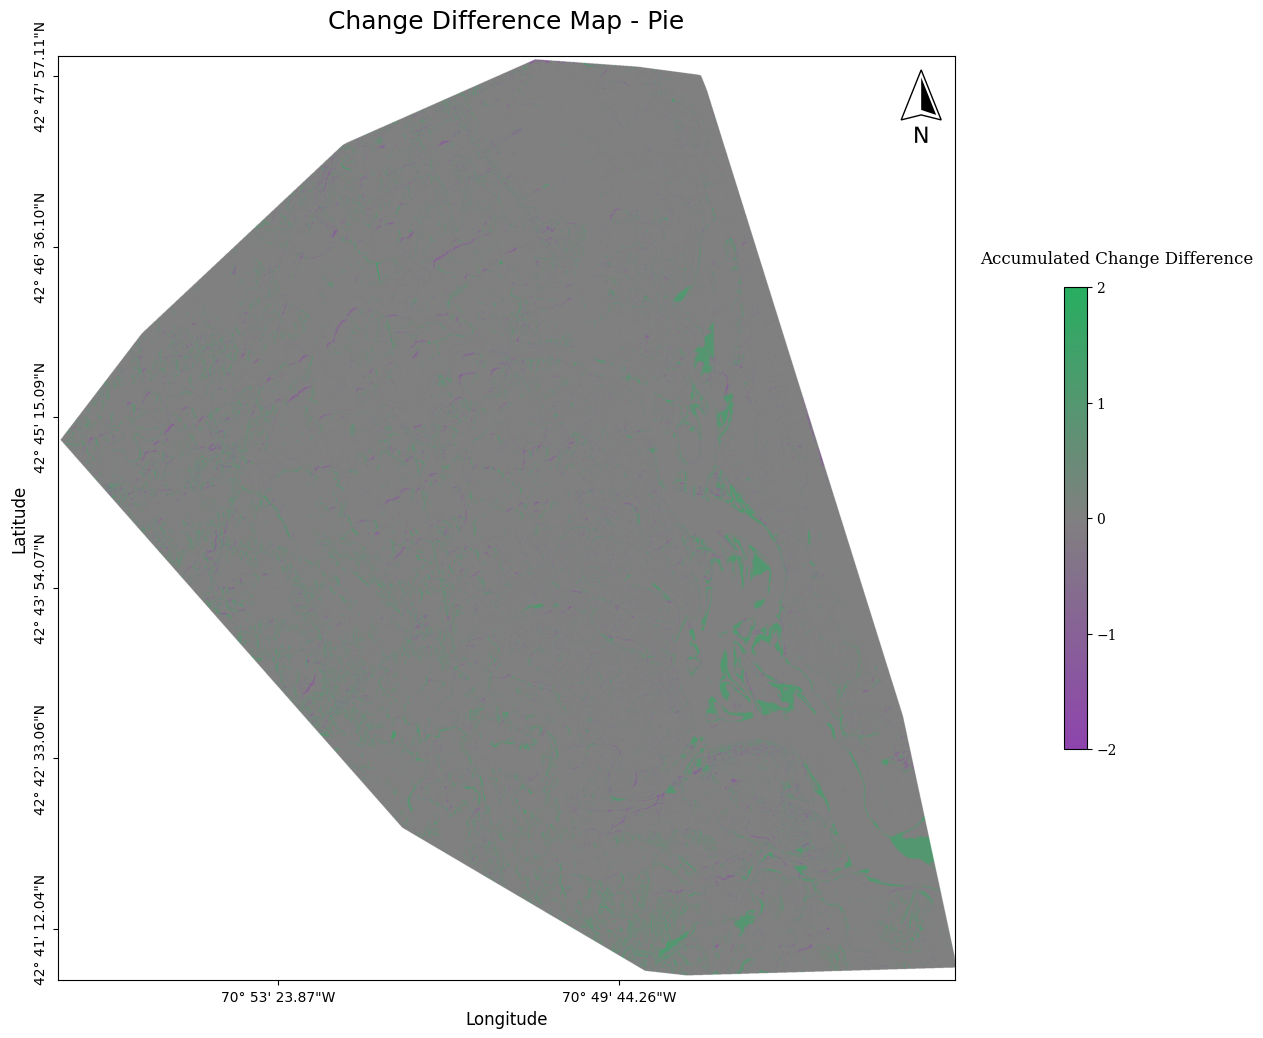


✅ Map visualization saved to: C:\Users\AntFonseca\github\compare-time-series\output4\change_difference_signed_PIE_map.png


In [ ]:
# =============================================================================
# Change DIFFERENCE (signed, Eq. 53) — 0 = gray, NoData = white
# Diverging purple → gray → green; integer ticks if binary
# =============================================================================
print("Generating the (signed) Change Difference map visualization...")

input_map_filename = f'change_difference_signed_{class_name}.tif'
input_map_path = os.path.join(output_path, input_map_filename)
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)
    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor),
                   int(src.width * scale_factor)),
        resampling=Resampling.nearest
    )

# mask NoData
masked_map = np.ma.masked_equal(data, nodata_value)

# diverging colormap centered at zero
cmap_div = mcolors.LinearSegmentedColormap.from_list(
    "purple_gray_green", ["#8e44ad", "gray", "#27ae60"]
)
cmap_div.set_bad(color="white")

# symmetric norm around 0
max_abs_val = float(np.ma.max(np.abs(masked_map))) if masked_map.count() > 0 else 1.0
norm_div = mcolors.Normalize(vmin=-max_abs_val, vmax=max_abs_val)

# tick formatters (DMS)
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    d = int(abs(lon)); m = int((abs(lon) - d) * 60)
    s = ((abs(lon) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    d = int(abs(lat)); m = int((abs(lat) - d) * 60)
    s = ((abs(lat) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("N" if lat >= 0 else "S")

fig, ax = plt.subplots(figsize=(14, 12))
mpl.rcParams['font.family'] = 'serif'

im = ax.imshow(
    masked_map,
    cmap=cmap_div,
    norm=norm_div,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)

ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
plt.setp(ax.get_yticklabels(), rotation=90, va='center')

north_arrow(ax, location="upper right", rotation={"degrees": 0}, shadow=False)
scalebar = ScaleBar(1/1000, units='km', length_fraction=0.4,
                    location='lower right',
                    scale_formatter=lambda value, _: f"{int(value)} km")
ax.add_artist(scalebar)

cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='vertical',
    fraction=0.046,
    pad=0.1,
    shrink=0.5
)
cbar.set_label(
    'Accumulated Change Difference',
    fontsize=12,
    rotation=0,
    y=1.08,
    labelpad=0
)

if is_binary_data:
    # integer ticks covering current data range
    vmin, vmax = np.ma.min(masked_map), np.ma.max(masked_map)
    cbar.set_ticks(np.arange(np.floor(vmin), np.ceil(vmax) + 1, 1))
else:
    cbar.set_ticks(np.linspace(-max_abs_val, max_abs_val, num=7))

ax.set_aspect('equal')
ax.set_title(f'Change Difference Map - {class_name.capitalize()}',
             fontsize=18, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

out_signed_png = os.path.join(output_path, f'change_difference_signed_{class_name}_map.png')
plt.savefig(out_signed_png, dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✅ Map visualization saved to: {out_signed_png}")


Generating the (absolute) Change Difference map visualization...


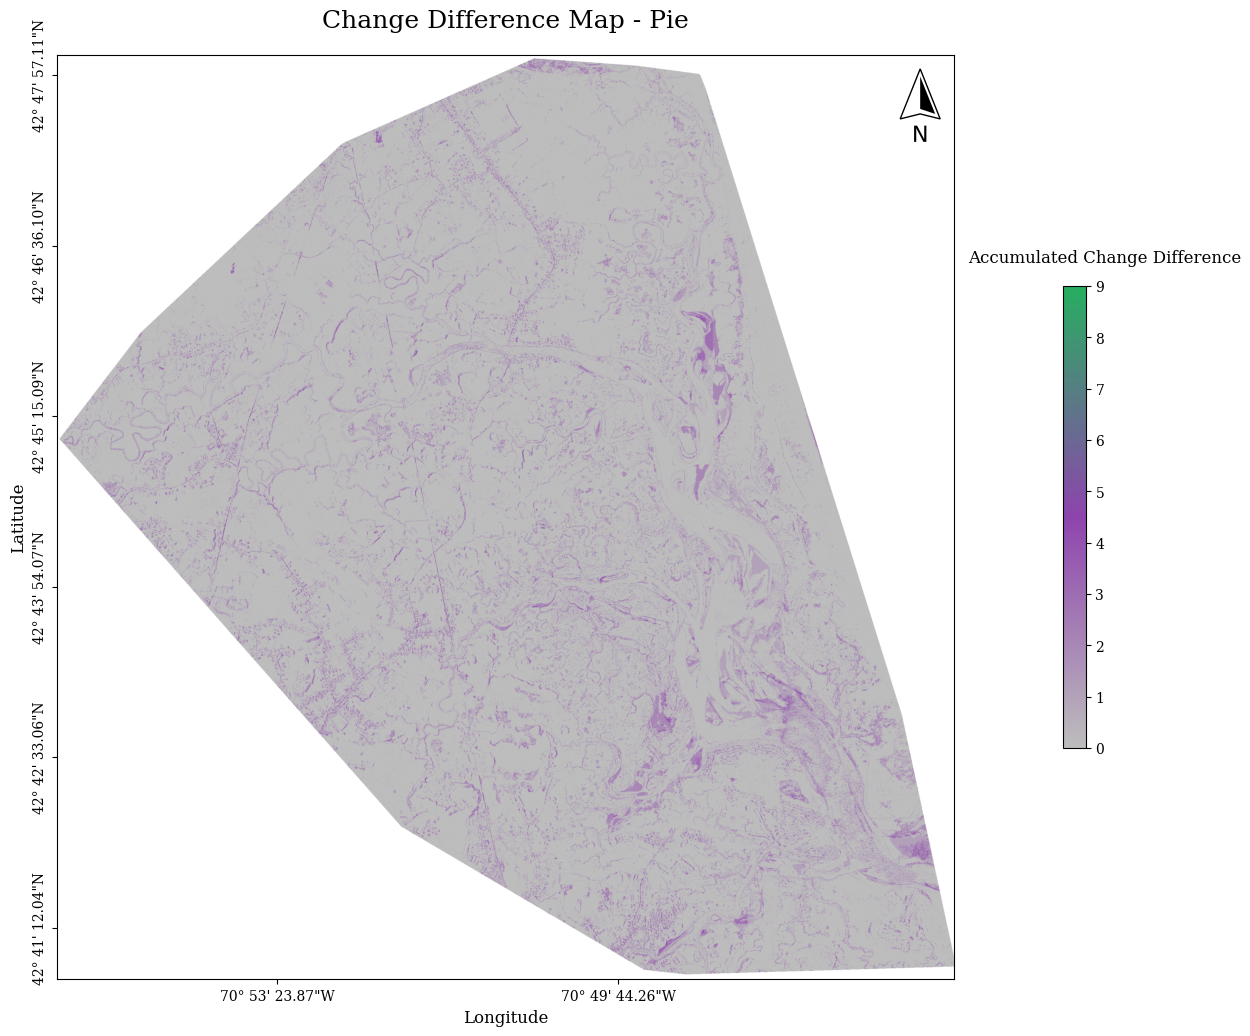


✅ Map visualization saved to: C:\Users\AntFonseca\github\compare-time-series\output4\change_difference_absolute_PIE_map.png


In [ ]:
# =============================================================================
# Change DIFFERENCE (absolute, Eq. 54) — 0 = gray, NoData = white
# Sequential gray → purple → green; integer ticks if binary
# =============================================================================
print("Generating the (absolute) Change Difference map visualization...")

input_map_filename = f'change_difference_absolute_{class_name}.tif'
input_map_path = os.path.join(output_path, input_map_filename)
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)
    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor),
                   int(src.width * scale_factor)),
        resampling=Resampling.nearest
    )

# mask NoData
masked_map = np.ma.masked_equal(data, nodata_value)

# sequential colormap gray -> purple -> green
cmap_seq = mcolors.LinearSegmentedColormap.from_list(
    "gray_purple_green", ["#bdbdbd", "#8e44ad", "#27ae60"]
)
cmap_seq.set_bad(color="white")

max_val = float(np.ma.max(masked_map)) if masked_map.count() > 0 else 1.0
norm_seq = mcolors.Normalize(vmin=0.0, vmax=max_val)

# tick formatters (DMS)
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    d = int(abs(lon)); m = int((abs(lon) - d) * 60)
    s = ((abs(lon) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    d = int(abs(lat)); m = int((abs(lat) - d) * 60)
    s = ((abs(lat) - d) * 60 - m) * 60
    return f"{d}° {m}' {s:.2f}\"" + ("N" if lat >= 0 else "S")

fig, ax = plt.subplots(figsize=(14, 12))
mpl.rcParams['font.family'] = 'serif'

im = ax.imshow(
    masked_map,
    cmap=cmap_seq,
    norm=norm_seq,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)

ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
plt.setp(ax.get_yticklabels(), rotation=90, va='center')

north_arrow(ax, location="upper right", rotation={"degrees": 0}, shadow=False)
scalebar = ScaleBar(1/1000, units='km', length_fraction=0.4,
                    location='lower right',
                    scale_formatter=lambda value, _: f"{int(value)} km")
ax.add_artist(scalebar)

cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='vertical',
    fraction=0.046,
    pad=0.1,
    shrink=0.5
)
cbar.set_label(
    'Accumulated Change Difference',
    fontsize=12,
    rotation=0,
    y=1.08,
    labelpad=0
)

if is_binary_data:
    # per-interval |Δy-Δx| ∈ {0,1,2}; sum over N intervals ⇒ 0..2N
    n_int = max(0, len(time_points) - 1)
    tick_max = int(np.floor(max_val))
    step = max(1, (tick_max // 5) or 1)
    cbar.set_ticks(np.arange(0, tick_max + 1, step))
else:
    cbar.set_ticks(np.linspace(0, max_val, num=6))

ax.set_aspect('equal')
ax.set_title(f'Change Difference Map - {class_name.capitalize()}',
             fontsize=18, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

out_abs_png = os.path.join(output_path, f'change_difference_absolute_{class_name}_map.png')
plt.savefig(out_abs_png, dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✅ Map visualization saved to: {out_abs_png}")
